
Use the Lehman rep package for fast fourier transforms to
solve the self-consistent equations directly at very low temperatures

A large-N Schwinger boson solver based on a forward fixed-point iteration method.

The self-energy of bosons and holons are given by,

   Σ_B(τ) = - γ G_c(τ) * G_h(τ),

   Σ_h(τ) = - G_c(β - τ) * G_b(τ),
   
where the boson and holon Green's function are given by the Dyson equation,

   G_B(iωₙ) = 1/(iνₙ - λ - Σ_B(iνₙ))

   G_h(iωₙ) = 1/(-1/J_K - Σ_h(iνₙ))

Furthermore, we need to enforce the Lagrange multiplier constraint, such that the
boson occupation number is maintained at q= 2S/N (a pre-defined and constant scalar).
This leads to 

n_b(λ) = G_b (τ = 0-) = q

Therefore, one needs to find the correct λ to satisfy this.

We solve the Dyson equation self-consistently by a weighted fixed point iteration, 
with weight `mix` assigned to the new iterate and weight `1-mix` assigned to the previous iterate. 
mix can be rather big for this non-critical system.
 
The self-energy is evaluated in the imaginary time domain, 
and the Dyson equation is solved in the Matsubara frequency domain.

**In this version, we use the GreenFunc package**


Important links as I write this code.

https://numericaleft.github.io/Lehmann.jl/dev/lib/spectral/ 

https://arxiv.org/pdf/2107.13094.pdf

https://en.wikipedia.org/wiki/Matsubara_frequency



**This is a list of the items to be implemented on this notebook**

- [ ] Include GreenFunc package and format things accordingly. 
- [X] Write a correct root finder solution to \lambda in order to implement the constraint
- [X] Stabilize the self-energy loop
- [ ] Create a function that solves the self-energy equations and returns Gh and GB for a given \beta
- [ ] Create a check function that finds the self-energies after the loop from G and the self-energies from the equations, and compares the two
- [ ] Measurements based on these obtaines green's functions, as a check of whether we are correctly solving the problem. Holon phase shift, spin susceptibility, ...
- [ ] This may require analytic continuation to order G(\omega). Is this avoidable?

In [28]:
using Lehmann
using Printf
using Roots
using GreenFunc

diff(a, b) = maximum(abs.(a - b)) # return the maximum deviation between a and b
diff_modulated(a, b) = sum(abs.(a - b)) /sum(abs.(b)) # return the maximum deviation between a and b

# Initialize DLR grid

rtol = 1e-8
β = 1000.0  #inverse temperature
Euv = 100 #UV cutoff
#df = DLRGrid(Euv = Euv, β = β, isFermi = true, rtol = rtol, symmetry = :none) #fermionic DLR grid
#db = DLRGrid(Euv = Euv, β = β, isFermi = false, rtol = rtol, symmetry = :none) #bosonic DLR grid
dlrmesh = DLRFreq(β, FERMION; Euv=5.0, rtol=rtol, symmetry=:ph)   # Initialize DLR grid

G_B = zeros(ComplexF64, length(db))
G_h = zeros(ComplexF64, length(df))
G_B_new = zeros(ComplexF64, length(db))
G_h_new = zeros(ComplexF64, length(df))
Sigma_B = zeros(ComplexF64, length(db)) 
Sigma_h = zeros(ComplexF64, length(df))
#some small broadening at the beginning is necessary
#Sigma_B = 1im*eta*ones(ComplexF64, length(db)) 
#Sigma_h = 1im*eta*ones(ComplexF64, length(df))

D = 20  #the half electronic bandwidth, needs to be smaller than Euv
ρ = 1/(2*D)
#below is the conduction electron bandwidth - this could be changed to be more "realistic"
G_c_matfreq = - ρ .* log.( (D .- df.ωn * 1im) ./ (- D .- df.ωn * 1im))
G_c = matfreq2tau(df, G_c_matfreq)

q0 = 0.5 # q0 = 2S/N
γ = q0  # γ ≠ q0 means a under or over screened Kondo model 
λ = (1/β) * log(1/q0 +1) #initial λ for the loop
eta = 0.001*λ
β_K = 50  #Kondo temperature, used to define J_K, needs to be larger than initial β
J_K = 1 / ρ / log(D * β_K) #alternatively, J_K could be defined by itself

#initialize G_B and G_h with their broadening factors.
#G_B = G_B .+ 1 ./(db.ωn * 1im .- λ + )
#G_h = G_h .- J_K #this is the initial value
#Sigma_B_matfreq = tau2matfreq(db, Sigma_B)
#Sigma_h_matfreq = tau2matfreq(df, Sigma_h)
#G_B_new = 1 ./(db.ωn * 1im .- λ .- 1im*eta*ones(ComplexF64, length(db)) ) #in omega freq
G_B_new = G_B_new + 1 ./(db.ωn * 1im .- λ) #in omega freq
G_h_new = G_h_new .+ 1 ./((-1.0 ./J_K )) #in omega freq
#in τ form
G_B = G_B + matfreq2tau(db, G_B_new)
G_h = G_h + matfreq2tau(df, G_h_new)

#change initial G_B and G_h to tau format

function nB_from_Gb_omega(Gfunc, dfreq, x)
   #feed in the freq. valued green's function
   new_Gfunc = 1.0 ./((1.0 ./Gfunc) .- x)
   all_G_tau_dlr = matfreq2tau(dfreq, new_Gfunc) #last element is G(τ = 0-)
   return -real(all_G_tau_dlr[end])
end

#plot sanity check
#using Plots
#plot(df.τ, real.(G_c))

G_B_omega = tau2matfreq(db, G_B)
f(x) = abs(q0 - nB_from_Gb_omega(G_B_omega, db, x)) #define the function for which the root needs to be found
xval = find_zero(f, 0, order=1) #find the root. x is such that λ_tot = λ + x
println("Initial Lagrange multiplier times β: $((λ + xval)*β), x=$xval and n_b - q = $(f(xval))")
#G_B_new = 1 ./(db.ωn * 1im .- λ .- xval .- 1im*eta*ones(ComplexF64, length(db)) ) #in omega freq
G_B_new = 1 ./(db.ωn * 1im .- λ .- xval) #in omega freq
G_B = matfreq2tau(db, G_B_new);


Initial Lagrange multiplier times β: 1.0986096342161917, x=-2.6544519180674814e-9 and n_b - q = 2.2652268949485688e-11


In [29]:
#iteration process
#needs to be put into a function
mix = 0.1
maxiter = 1000
numprint = 20
sumrule = nothing
verbose = true
tol = -maximum([-df.rtol * 10, -db.rtol * 10])
#tol = 1e-5

#conduction electron G does not change
tau_c = df.τ # DLR imaginary time nodes
tau_c_rev = df.β .- tau_c # Reversed imaginary time nodes
G_c_rev = tau2tau(df, G_c, tau_c_rev) # G_c at beta - tau_k

cont = 1
iter = 1
while cont == 1
   #old green's functions
   G_B_old = G_B
   G_h_old = G_h
   #self energy equations in τ
   Sigma_B = - γ .* G_h .* G_c
   Sigma_h = G_B .* G_c_rev
   #their ωn counterparts
   Sigma_B_matfreq = tau2matfreq(db, Sigma_B)
   Sigma_h_matfreq = tau2matfreq(df, Sigma_h)

   #define new G_B and G_h in ωn using the self-energy
   #1)
   #solve the Lagrange multiplier constraint with new G_B 
   G_B_omega = 1 ./(db.ωn * 1im .- λ.- Sigma_B_matfreq)
   f(x) = abs(q0 - nB_from_Gb_omega(G_B_omega, db, x)) #define the function for which the root needs to be found
   xval = find_zero(f, xval, order=1, atol=1e-3) #find the root. x is such that λ_tot = λ + x
   #2) create the new GB and Gh
   G_B_new = 1 ./(db.ωn * 1im .- λ .- xval .- Sigma_B_matfreq)
   G_h_new = 1 ./((- 1 ./J_K ) .- Sigma_h_matfreq)
   #convert them to τ space
   G_B_new_tau = matfreq2tau(db, G_B_new)
   G_h_new_tau = matfreq2tau(df, G_h_new)

   #mix old and new solutions together 
   G_B = mix * G_B_new_tau + (1 - mix) * G_B_old # Linear mixing
   G_h = mix * G_h_new_tau + (1 - mix) * G_h_old # Linear mixing

   #distance between old and new solution.
   dist_GB = diff_modulated(G_B, G_B_old)/mix
   dist_Gh = diff_modulated(G_B, G_B_old)/mix

   if sqrt(dist_GB^2 + dist_Gh^2) < tol || iter > maxiter
      cont = 0
   end

   if verbose && iter % (maxiter / numprint) == 0
      #println("round $iter: change B $(diff(G_B_old, G_B)) change χ $(diff(G_h_old, G_h))")
      println("round $iter: change B $dist_GB change χ $dist_Gh")
   end

   if verbose && iter % (maxiter / numprint) == 0
      println("Lagrange multiplier times β: $((λ + xval)*β) and n_b - q = $(f(xval))")
      println(" ")
   end

   iter += 1

   flush(stdout)

end

print("done in $iter steps")

round 50: change B 0.03560077820027369 change χ 0.03560077820027369
Lagrange multiplier times β: 12.35635262762238 and n_b - q = 0.0009343310414265948
 


round 100: change B 0.0012619749331062781 change χ 0.0012619749331062781
Lagrange multiplier times β: 20.998525775770762 and n_b - q = 7.815629343710384e-7
 


round 150: change B 6.430754479594823e-5 change χ 6.430754479594823e-5
Lagrange multiplier times β: 21.147816348851077 and n_b - q = 0.0005657367808499236
 


round 200: change B 4.004953087485749e-6 change χ 4.004953087485749e-6
Lagrange multiplier times β: 21.147816348851077 and n_b - q = 0.000680198723744696
 


round 250: change B 3.06655392622522e-7 change χ 3.06655392622522e-7
Lagrange multiplier times β: 21.147816348851077 and n_b - q = 0.0006899855304065561
 


done in 272 steps

In [31]:
#phase shift calculation - does not seem good
G_h_omega = tau2matfreq(df, G_h)
Sigma_h_one = matfreq2tau(df, - ((1.0 ./ G_h_omega) .- (- 1 ./J_K )))
Sigma_h_two = G_B .* G_c_rev
delta1 = -imag(log(J_K - sum(Sigma_h_two)/β))/π
#delta1 = imag(log(sum(G_h)/β))/π

7.760601052029793e-5

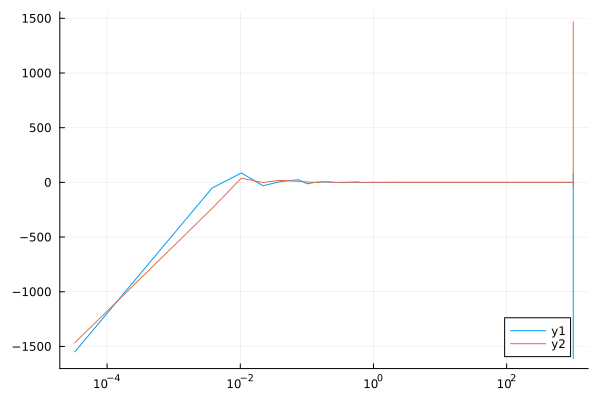

In [34]:
plot(df.τ, imag(G_h), xscale=:log10)
plot!(df.τ, real(G_h),xscale=:log10)

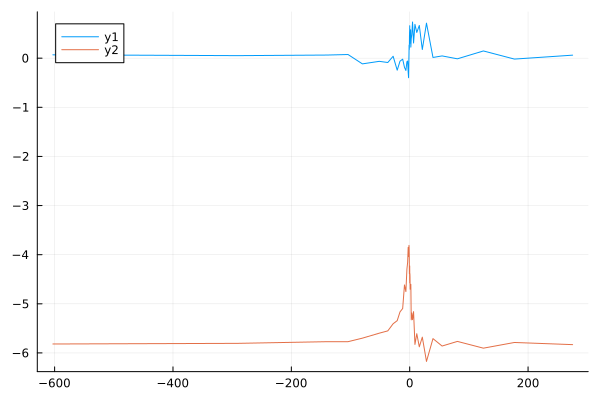

In [35]:
G_h_omega = tau2matfreq(df, G_h)
plot(df.ωn, imag(G_h_omega))
plot!(df.ωn, real(G_h_omega))


In [16]:
#test if the solutions work

#first version of Self energies
G_B_omega = tau2matfreq(db, G_B)
Sigma_B_one = matfreq2tau(db, - ((1.0 ./ G_B_omega) .- db.ωn * 1im .+ λ .+ xval))
G_h_omega = tau2matfreq(df, G_h)
Sigma_h_one = matfreq2tau(df, - ((1.0 ./ G_h_omega) .- (- 1 ./J_K )))

#conduction electron G does not change
Sigma_B_two = - γ .* G_h .* G_c
Sigma_h_two = G_B .* G_c_rev


println("check: Σ(1)_B - Σ(2)_B $(diff_modulated(Sigma_B_two, Sigma_B_one)) Σ(1)_χ - Σ(2)_χ $(diff_modulated(Sigma_h_two, Sigma_h_one))")

check: Σ(1)_B - Σ(2)_B 1.023590004274923e-5 Σ(1)_χ - Σ(2)_χ 1.7991510882772787e-5


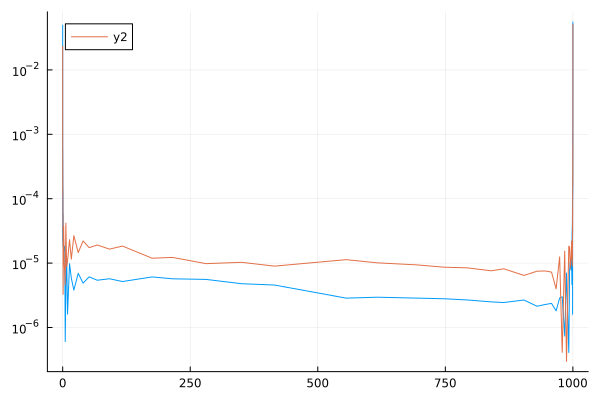

In [4]:
using Plots
plot(db.τ, abs.(imag(Sigma_B_one) - imag(Sigma_B_two)), yscale=:log10, label="")
plot!(db.τ, abs.(real(Sigma_B_one) - real(Sigma_B_two)), yscale=:log10)